# **How to forecast traffic speed using Residual Gated GCNN**

This notebook references the official PyTorch Geometric [implementation](https://pytorch-geometric.readthedocs.io/en/2.6.1/_modules/torch_geometric/nn/conv/res_gated_graph_conv.html#ResGatedGraphConv) of `ResGatedGraphConv`.

For more information check the original [paper](https://arxiv.org/abs/1711.07553).

## Introduction to Graph ML

**Note:** This section provides the foundational knowledge required for
understanding basic Graph Machine Learning principles. This material is essential for comprehending Residual Gated Graph ConvNets. If you are already familiar with these concepts, you may skip to the **Residual Gated Graph ConvNets - short overview** section.

## 1. What is a Graph?
A **graph** is a data structure defined by two sets: a set of **nodes** (or vertices) and a set of **edges**.
- **Nodes** represent entities or objects.
- **Edges** represent relationships or connections between pairs of nodes (which may be the same node in some cases).

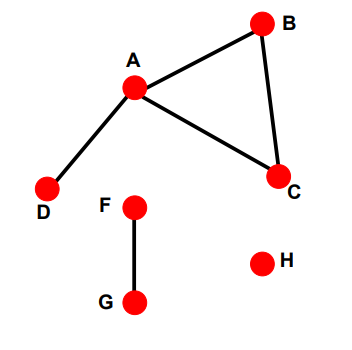

*Analogy:* Think of a graph as a physical pinboard. The nodes are the pins, and the edges are the threads connecting any two pins.

Both nodes and edges can possess attributes, known as **features**.

*Analogy:* Pins can have different colors, shapes, or sizes. Threads can vary in thickness, color, or material.

### Examples of structures that can be represented as graphs:

- **Example 1: Transportation Network**
    - **Nodes:** Cities
    - **Edges:** Roads connecting cities
    - **Node Features:** City name, population, area
    - **Edge Features:** Road length, type (highway, street)

- **Example 2: Social Network**
    - **Nodes:** People (students, users)
    - **Edges:** Relationships
    - **Node Features:** Names, Age, gender, interests
    - **Edge Features:** Type of relationship, date connection formed

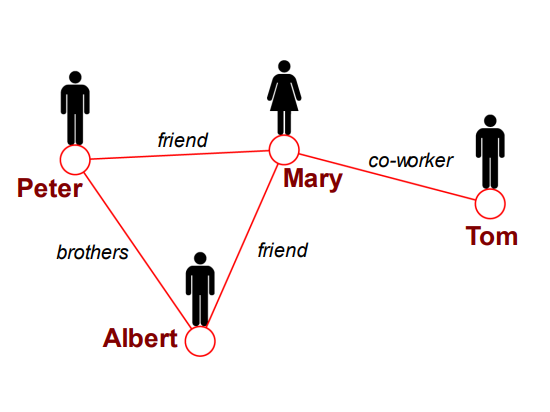

## 2. What is Graph ML?
The primary goal of Graph Machine Learning (Graph ML) is to learn meaningful representations (called **embeddings**) for nodes, edges, or the entire graph itself. This learning process utilizes two primary sources of information:

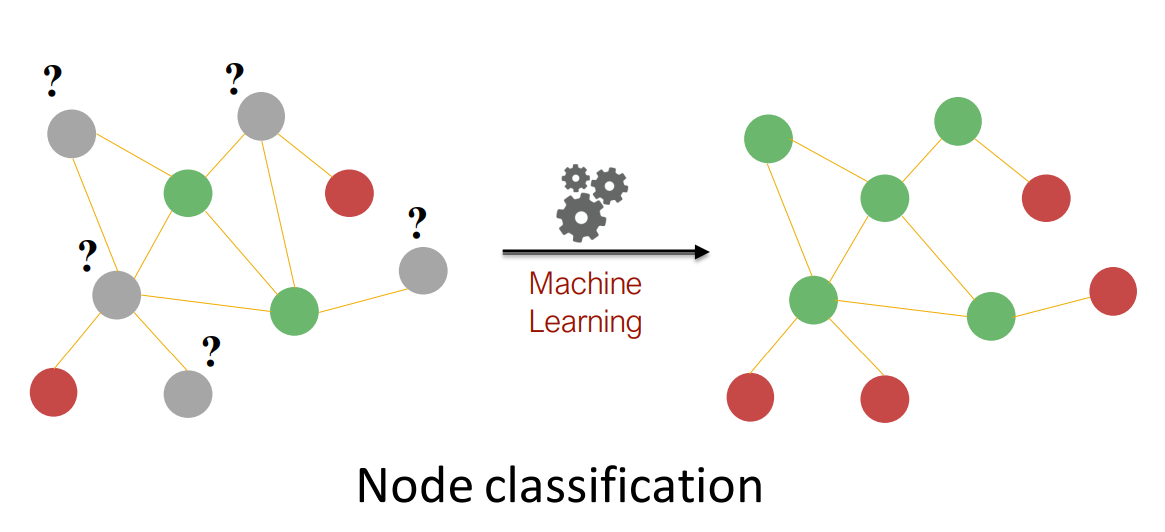

1.  **Node Features:** The intrinsic attributes or properties of each node (e.g., a user's profile information, an atom's type and charge).
2.  **Graph Structure:** The connectivity pattern defined by the edges, which captures the relationships and topology of the network.

The fundamental mechanism that enables modern Graph ML models to combine these information sources is called **Message Passing**.

## 3. Message Passing
Message Passing is a local, iterative, and parallelizable operation where nodes in a graph exchange information with their direct neighbors to update their own state. It is the core mechanism for propagating and diffusing feature information and structural information across the graph.

Conceptually, you can think of it as a distributed computation happening across the network. In each layer of a Graph Neural Network (GNN), every node performs the same three-step process:

1.  **Message:**
    Each node collects "messages" from its neighboring nodes. A message is typically a transformed version of a neighbor's feature vector or hidden state.

2.  **Aggregate:**
    The node combines all the received messages from its neighbors into a single, summarized vector. Common aggregation functions include:
    - **Sum:** Adding all the message vectors.
    - **Mean:** Averaging all the message vectors.
    - **Max:** Taking the element-wise maximum across all message vectors.

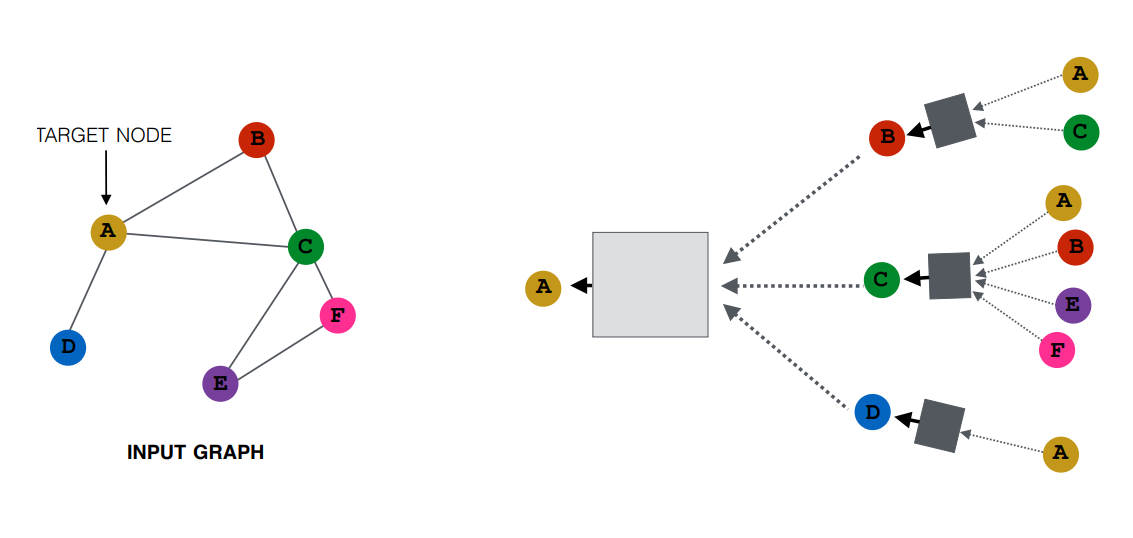

3.  **Update:**
    The node combines its own previous state (or its original features) with the newly aggregated message from its neighbors to produce its updated state for the next layer. This is often done using a learnable function like a neural network.

## *Residual Gated Graph Convolutional Neural Networks* - short overview

### 1. What problem does it solve?

- Graph neural networks aggregate information from neighbours to compute new node representations.
- `ResGatedGraphConv` augments a message-passing layer with **edge gating** (learned scalar gates per edge) and **residual/skip connections**.

### 2. Mathematical formulation

The operator implemented in PyG computes (for a node $i$):

$$\mathbf{x}'_i = \mathbf{W}_1 \mathbf{x}_i + \sum_{j\in \mathcal{N}(i)} \eta_{i,j} \odot \mathbf{W}_2 \mathbf{x}_j$$

where the gate $\eta_{i,j}$ is computed as:

$$\eta_{i,j} = \sigma(\mathbf{W}_3 \mathbf{x}_i + \mathbf{W}_4 \mathbf{x}_j)$$

with $\sigma$ the sigmoid function. The gates are element-wise (i.e., they have the same dimensionality as the transformed features), allowing anisotropic modulation of the neighbor messages.

**Intuition:** the gate lets the model control how much information travels from neighbor $j$ into node $i$ for each feature dimension. Residual connection (adding a transformed `x_i`) stabilizes training and helps deeper stacking.

### 3. Key design choices and benefits

- **Edge gating:** differentiable, learned gating that can depend on both source and target node features (and optionally edge features). Helps the network ignore irrelevant neighbors or attenuate noisy signals.
- **Residual (root) contribution:** adding a transformed version of the central (root) node features to the aggregated message — analogous to ResNet skip-connections — improves gradient flow and enables deeper GNNs.
- **Separation of key/query/value:** the implementation uses distinct linear transforms for keys, queries and values (naming inspired by attention), enabling flexible combinations of source/target representation spaces.

### 4. When to use

- When you suspect neighbors have varying relevance and you want the model to learn per-edge importance.
- In tasks that benefit from deeper GNN stacks — residual links help with stability.

## Method implementation

Now we will implement class `ResGatedGraphConv`from scratch.

**Imports:**

In [ ]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 22.9 MB/s eta 0:00:00


In [ ]:
from typing import Callable, Optional, Tuple, Union

import torch
from torch import Tensor
from torch.nn import Parameter, Sigmoid

from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.dense.linear import Linear
from torch_geometric.nn.inits import zeros
from torch_geometric.typing import Adj, OptTensor, PairTensor

`MessagePassing`: implements the message/aggregate/update loop.

`Linear`: behaves like nn.Linear.

`zeros`: sets all values in a parameter tensor to 0 (just like tensor.data.zero().

`Adj, OptTensor, PairTensor`: type aliases used for annotation and clarity, help document what kinds of data the layer can accept.



**Class constructor:**

In [ ]:
def __init__(
        self,
        in_channels: Union[int, Tuple[int, int]], # int or (in_src, in_dst) tuple for bipartite graphs.
                                                  # If single int, the layer assumes source and target have same feature size.

        out_channels: int,                        # output feature size
        act: Optional[Callable] = Sigmoid(),      # gating function; default Sigmoid() to produce gates ∈ (0,1)
        edge_dim: Optional[int] = None,           # if you have edge features, this is their dimension

        root_weight: bool = True,                 # if True, the layer will add a transformed copy of the central node (W_1 x_i) — the residual/skip term.
                                                  # If False, no skip is added.

        bias: bool = True,                        # additive bias vector of shape (out_channels,)
        **kwargs,
    ):

        kwargs.setdefault('aggr', 'add')          # default aggregation is 'add' (you can change to 'mean')
        super().__init__(**kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.act = act
        self.edge_dim = edge_dim
        self.root_weight = root_weight

        if isinstance(in_channels, int):
            in_channels = (in_channels, in_channels)

        edge_dim = edge_dim if edge_dim is not None else 0

        self.lin_key = Linear(in_channels[1] + edge_dim, out_channels)    # transforms target (destination) node features (and edge attrs if present)
        self.lin_query = Linear(in_channels[0] + edge_dim, out_channels)  # transforms source node features (and edge attrs if present) used to compute the gate
        self.lin_value = Linear(in_channels[0] + edge_dim, out_channels)  # transforms source node features (and edge attrs if present) into the message/value

        # if True we create a Linear that maps target node features -> out_channels
        # we set bias=False because a separate bias parameter is stored (self.bias)
        if root_weight:
            self.lin_skip = Linear(in_channels[1], out_channels, bias=False)
        else:
            self.register_parameter('lin_skip', None)

        if bias:
            self.bias = Parameter(Tensor(out_channels))
        else:
            self.register_parameter('bias', None)

        # initialize all parameters
        self.reset_parameters()

**Parameters initialization:**

In [ ]:
def reset_parameters(self):
  super().reset_parameters()
  self.lin_key.reset_parameters()
  self.lin_query.reset_parameters()
  self.lin_value.reset_parameters()
  if self.lin_skip is not None:
      self.lin_skip.reset_parameters()
  if self.bias is not None:
      zeros(self.bias)

**How data flows through the layer:**

In [ ]:
def forward(
    self,
    x: Union[Tensor, PairTensor],
    edge_index: Adj,
    edge_attr: OptTensor = None,
) -> Tensor:

    # normalize to a pair (x_src, x_dst) for uniform handling
    if isinstance(x, Tensor):
        x = (x, x)

    # in case edge features are not given, we can compute key, query and
    # value tensors in node-level space, which is a bit more efficient
    if self.edge_dim is None:
        k = self.lin_key(x[1])
        q = self.lin_query(x[0])
        v = self.lin_value(x[0])
    else:
        k, q, v = x[1], x[0], x[0]

    # aggregation
    out = self.propagate(edge_index, k=k, q=q, v=v, edge_attr=edge_attr)

    # add skip term on central node
    if self.root_weight:
        out = out + self.lin_skip(x[1])

    # add global bias vector
    if self.bias is not None:
        out = out + self.bias

    # return final (N_dst, out_channels) features
    return out

`propagate(...)` triggers the message/aggregation pipeline. It internally:

For each edge j -> i:

*   calls `message(k_i, q_j, v_j, edge_attr)`
*   aggregates messages for each target i using aggr='add'

returns out shape (N_dst, out_channels).

**Message-passing:**

In [ ]:
def message(self,
            k_i: Tensor,                                          # transformed target node features (or raw if edge_attr exists and pretransform postponed)
            q_j: Tensor,                                          # transformed source node features (query)
            v_j: Tensor,                                          # source value features used as the message payload
            edge_attr: OptTensor) -> Tensor:

  # prevents silent bugs where shapes mismatch
  assert (edge_attr is not None) == (self.edge_dim is not None)

  if edge_attr is not None:

      # Concatenate target node features k_i with the corresponding edge attributes,
      # then apply the lin_key layer to produce the per-edge key vector:
      # input shape -> (E, in_dst + edge_dim), output -> (E, out_channels)
      k_i = self.lin_key(torch.cat([k_i, edge_attr], dim=-1))

      # Same for source/query: concatenate source features with edge_attr, then project.
      # input -> (E, in_src + edge_dim), output -> (E, out_channels)
      q_j = self.lin_query(torch.cat([q_j, edge_attr], dim=-1))

      # And for the value: concatenate and project to the message/value space.
      # This yields v_j shaped (E, out_channels) for elementwise gating below.
      v_j = self.lin_value(torch.cat([v_j, edge_attr], dim=-1))

  # Multiply the gate elementwise with the value vector v_j to get the final per-edge message.
  # This implements: message_{i<-j} = σ(W3 x_i + W4 x_j) ⊙ (W2 x_j)
  return self.act(k_i + q_j) * v_j

**Shapes recap:**

Assume:

* `N` nodes (same for src & dst),
* `E` edges,
* node features `x` shape `(N, F_in)`,
* `edge_attr` shape `(E, edge_dim)` if present,
* `out_channels = F_out`.

**Case no edge features:**

* k: (N, F_out), q: (N, F_out), v: (N, F_out).
* For edges, `message` receives `k_i` as `(E, F_out)` (target features repeated per incoming edge), `q_j` and `v_j` as `(E, F_out)`.
* Gate: `(E, F_out)` after sigmoid. Message: `(E, F_out)`.
* Aggregation: `out` per node is sum across incoming edges → `(N, F_out)`.
* Add `lin_skip(x_dst): (N, F_out)`.

**Case with edge features:**

* k,q,v initially are raw node features (N, F_in); inside message, torch.cat([k_i, edge_attr], dim=-1) yields (E, F_in + edge_dim). lin_key/lin_query/lin_value produce (E, F_out).

**Putting all together:**

In [ ]:
class ResGatedGraphConv(MessagePassing):
    def __init__(
        self,
        in_channels: Union[int, Tuple[int, int]],
        out_channels: int,
        act: Optional[Callable] = Sigmoid(),
        edge_dim: Optional[int] = None,
        root_weight: bool = True,
        bias: bool = True,
        **kwargs,
    ):

        kwargs.setdefault('aggr', 'add')
        super().__init__(**kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.act = act
        self.edge_dim = edge_dim
        self.root_weight = root_weight

        if isinstance(in_channels, int):
            in_channels = (in_channels, in_channels)

        edge_dim = edge_dim if edge_dim is not None else 0
        self.lin_key = Linear(in_channels[1] + edge_dim, out_channels)
        self.lin_query = Linear(in_channels[0] + edge_dim, out_channels)
        self.lin_value = Linear(in_channels[0] + edge_dim, out_channels)

        if root_weight:
            self.lin_skip = Linear(in_channels[1], out_channels, bias=False)
        else:
            self.register_parameter('lin_skip', None)

        if bias:
            self.bias = Parameter(Tensor(out_channels))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

    def reset_parameters(self):
        super().reset_parameters()
        self.lin_key.reset_parameters()
        self.lin_query.reset_parameters()
        self.lin_value.reset_parameters()
        if self.lin_skip is not None:
            self.lin_skip.reset_parameters()
        if self.bias is not None:
            zeros(self.bias)

    def forward(
        self,
        x: Union[Tensor, PairTensor],
        edge_index: Adj,
        edge_attr: OptTensor = None,
    ) -> Tensor:

        if isinstance(x, Tensor):
            x = (x, x)

        if self.edge_dim is None:
            k = self.lin_key(x[1])
            q = self.lin_query(x[0])
            v = self.lin_value(x[0])
        else:
            k, q, v = x[1], x[0], x[0]

        out = self.propagate(edge_index, k=k, q=q, v=v, edge_attr=edge_attr)

        if self.root_weight:
            out = out + self.lin_skip(x[1])

        if self.bias is not None:
            out = out + self.bias

        out = self.act(out)
        out = self.dropout(out)
        return out

    def message(self, k_i: Tensor, q_j: Tensor, v_j: Tensor,
                edge_attr: OptTensor) -> Tensor:

        assert (edge_attr is not None) == (self.edge_dim is not None)

        if edge_attr is not None:
            k_i = self.lin_key(torch.cat([k_i, edge_attr], dim=-1))
            q_j = self.lin_query(torch.cat([q_j, edge_attr], dim=-1))
            v_j = self.lin_value(torch.cat([v_j, edge_attr], dim=-1))

        return self.act(k_i + q_j) * v_j

## A real-world task: traffic speed forecasting

Up to now we have focused on **how** Residual Gated Graph ConvNets work on an abstract graph:
- nodes exchange messages with their neighbors,
- edge gates control how much information flows along each connection,
- residual connections stabilize deep stacks of layers.

We now **instantiate** this abstract graph on a concrete problem: **predicting future traffic speeds on a large highway network (METR-LA)**.

- **Graph instantiation**:
  - Each **node** is a highway loop detector (sensor) in Los Angeles.
  - Directed **edges** encode how traffic can flow from one sensor to another, weighted by physical distance or connectivity strength.
  - **Edge features** (weights) tell the model which connections are more influential.

- **Spatio-temporal learning pipeline**:
  1. Build a **graph** from the road network (adjacency matrix → `edge_index`, `edge_attr`).
  2. For each sensor, take a **window of past speeds** (e.g., the last 36×5 minutes) as node features.
  3. Apply a **temporal convolution** to capture short-term dynamics (rush-hour peaks, sudden drops).
  4. Apply several **Residual Gated GraphConv layers** to propagate information along the road network and capture multi-hop spatial effects.
  5. Use a final linear layer to output **multi-horizon forecasts** (e.g., 5, 15, 30, 60 minutes ahead) for every sensor.

- **Why this method is suitable for road traffic prediction?**
  - It respects the **network structure** of roads: predictions for one sensor depend on its neighbors and their neighbors.
  - The **gates on edges** allow the model to learn which connections are truly important (e.g., major highways vs. minor roads), instead of assuming all neighbors contribute equally.
  - **Residual connections** help train deeper models that can capture long-range dependencies without degrading performance.
  - Combining **temporal convolutions** with **graph convolutions** yields a model that jointly learns **when** and **where** congestion patterns emerge and propagate.

With this high-level picture in mind, we now move on to loading the METR-LA dataset and constructing the corresponding traffic graph.


## Dataset

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data, Dataset
from sklearn.preprocessing import StandardScaler
import pickle
from torch import nn

## Load traffic dataset and ready adjecency matrix
1. METR-LA dataset is a benchmark dataset for traffic forecasting. A dataset containing the traffic network information in Los Angeles city from March to Jun 2012.
[METR-LA dataset](https://www.kaggle.com/datasets/annnnguyen/metr-la-dataset)
```
Structure:
(
    timestamps every 5 min,
    speed in miles/hour for each 207 sensor
)
```

2. adj_mx.pkl - the traffic network graph.
This file stores the graph structure of the Los Angeles highway sensor network.
```
Structure:
(
    sensor_ids,        # list of real sensor IDs (strings)
    sensor_id_to_ind,  # mapping from real sensor ID to node index in the graph
    adj_mx             # adjacency matrix (207 × 207)
)
```

In [ ]:
!wget https://raw.githubusercontent.com/liyaguang/DCRNN/master/data/sensor_graph/adj_mx.pkl -O adj_mx.pkl

--2025-11-30 13:34:23--  https://raw.githubusercontent.com/liyaguang/DCRNN/master/data/sensor_graph/adj_mx.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 680459 (665K) [text/plain]
Saving to: ‘adj_mx.pkl’

adj_mx.pkl          100%[===================>] 664.51K  --.-KB/s    in 0.04s   

2025-11-30 13:34:23 (16.2 MB/s) - ‘adj_mx.pkl’ saved [680459/680459]



In [ ]:
import gdown

file_id = "1pAGRfzMx6K9WWsfDcD1NMbIif0T0saFC"
url = f"https://drive.google.com/uc?export=download&id={file_id}"

output = "metr-la.h5"
gdown.download(url, output, quiet=False)


Downloading...
From: https://drive.google.com/uc?export=download&id=1pAGRfzMx6K9WWsfDcD1NMbIif0T0saFC
To: /content/metr-la.h5
100%|██████████| 57.0M/57.0M [00:00<00:00, 184MB/s]


'metr-la.h5'

In [ ]:
# load h5 file an return speed matrix
def load_h5_speed(file_path):
    df = pd.read_hdf(file_path)
    df.index = pd.to_datetime(df.index)
    speeds = df.values.astype(np.float32)
    print("Loaded speed matrix:", speeds.shape)

    return speeds, list(df.index)

In [ ]:
def adj_to_edge_index(adj):
    # Find connected edges
    rows, cols = np.where(adj > 0)
    edge_index_np = np.stack([rows, cols], axis=0)

    edge_index = torch.from_numpy(edge_index_np).long() # pairs of connected node indices
    edge_attr = torch.from_numpy(
        adj[rows, cols].astype(np.float32)
        ).unsqueeze(1)  # stores weights

    return edge_index, edge_attr

In [ ]:
def load_adj_mx(path):
    # sensor_ids,        # list of real sensor IDs (strings)
    # sensor_id_to_ind,  # mapping from real sensor ID to node index in the graph
    # adj_mx             # adjacency matrix (207 × 207)

    with open(path, "rb") as f:
        sensor_ids, sensor_id_to_ind, adj_mx = pickle.load(f, encoding="latin1")

    adj = np.array(adj_mx)
    N = adj.shape[0]

    print("Loaded METR-LA adjacency:")
    print("Num sensors:", N)
    print("Adj shape:", adj.shape)

    return sensor_ids, sensor_id_to_ind, adj

In [ ]:
def make_pyg_graph(edge_index, edge_attr, num_nodes):
    return Data(
        edge_index=edge_index,
        edge_attr=edge_attr,
        num_nodes=num_nodes
    )

**Nodes:**

Each node represents a traffic sensor in Los Angeles.

The features of a node are the past traffic speed readings for that sensor over seq_len time steps.

Example: If seq_len=36, then for one node, x is a vector of 36 past speed values (or a 36-dimensional feature vector).

**Edges (edge_index and edge_attr)**:

Edges represent connections between sensors, typically based on the physical road network.

edge_index contains the pairs of nodes that are connected: [from_node, to_node].

edge_attr contains the weight of each edge, usually a function of distance or similarity between sensors. Shorter distances → stronger influence.

Self-loops are included so that a sensor’s past value can directly influence its own prediction.

### How the traffic graph feeds into our Residual Gated GCNN

Summarizing the graph construction in the context of our model:

- **Node features (temporal context):** for each sensor, we take the last `seq_len` speed measurements. This short time window captures recent dynamics (build-up and dissipation of congestion).
- **Edge structure (spatial context):** `edge_index` and `edge_attr` describe who is connected to whom and how strongly. This encodes the physical road layout and typical influence patterns between sensors.
- **Graph message passing:** at each Residual Gated GraphConv layer, a sensor updates its representation by aggregating messages from its neighbors along these edges.
- **Gating on edges:** the learned gates decide which neighbor connections matter most for predicting future speeds, allowing the model to focus on major corridors and down-weight less informative links.
- **Residual stacking:** multiple such layers are stacked with residual connections, enabling the model to capture **multi-hop propagation of traffic conditions** (e.g., how a bottleneck several links away affects a given sensor) while remaining trainable.

Because congestion propagates along the road network in space and evolves over time, this combination of **temporal history + gated graph message passing** is particularly suitable for accurate, multi-step traffic speed forecasting.


In [ ]:
class TrafficDatasetMultiHorizon(Dataset):
    def __init__(self, speed_matrix, graph, seq_len=12, horizon_steps=[3,6,12]):
        """
        speed_matrix: [T, N]
        seq_len: number of past time steps used as input (e.g., 12 × 5min = 1 hour)
        horizon_steps: future prediction offsets (e.g., 3=15min, 6=30min, 12=60min ahead)
        """
        super().__init__()
        self.speed = speed_matrix
        self.graph = graph
        self.seq_len = seq_len
        self.horizon_steps = horizon_steps

        self.scaler = StandardScaler()
        self.speed_norm = self.scaler.fit_transform(self.speed)

    def __len__(self):
        return len(self.speed_norm) - self.seq_len - max(self.horizon_steps)

    def __getitem__(self, idx):
        x = self.speed_norm[idx:idx+self.seq_len] # past history

        # extract multi-horizon future targets: list of N-length vectors at each horizon
        y = np.array([self.speed_norm[idx+self.seq_len+h] for h in self.horizon_steps]).T

        x = torch.tensor(x).float().t()
        y = torch.tensor(y).float() # future values to predict

        return Data(
            x=x,
            y=y,
            edge_index=self.graph.edge_index,
            edge_attr=self.graph.edge_attr,
            num_nodes=self.graph.num_nodes
        )


In [ ]:
speeds, timestamps = load_h5_speed("metr-la.h5")
sensor_ids, id_map, adj = load_adj_mx("adj_mx.pkl")

Loaded speed matrix: (34272, 207)
Loaded METR-LA adjacency:
Num sensors: 207
Adj shape: (207, 207)


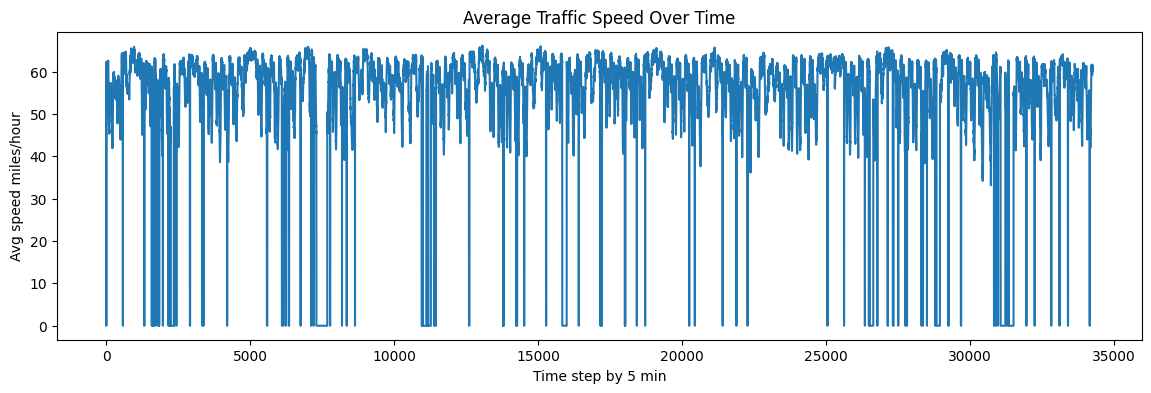

In [ ]:
plt.figure(figsize=(14,4))
plt.plot(np.mean(speeds, axis=1))
plt.title("Average Traffic Speed Over Time")
plt.xlabel("Time step by 5 min")
plt.ylabel("Avg speed miles/hour")
plt.show()

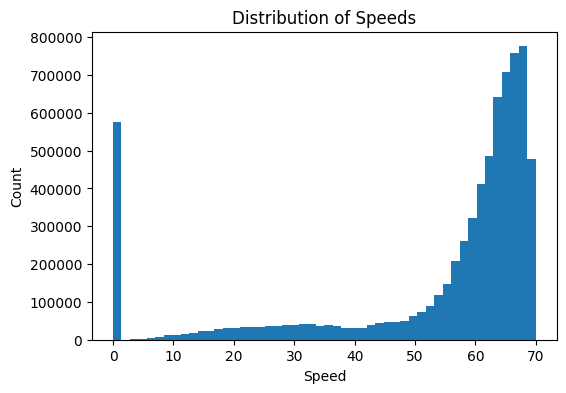

In [ ]:
plt.figure(figsize=(6,4))
plt.hist(speeds.reshape(-1), bins=50)
plt.title("Distribution of Speeds")
plt.xlabel("Speed")
plt.ylabel("Count")
plt.show()

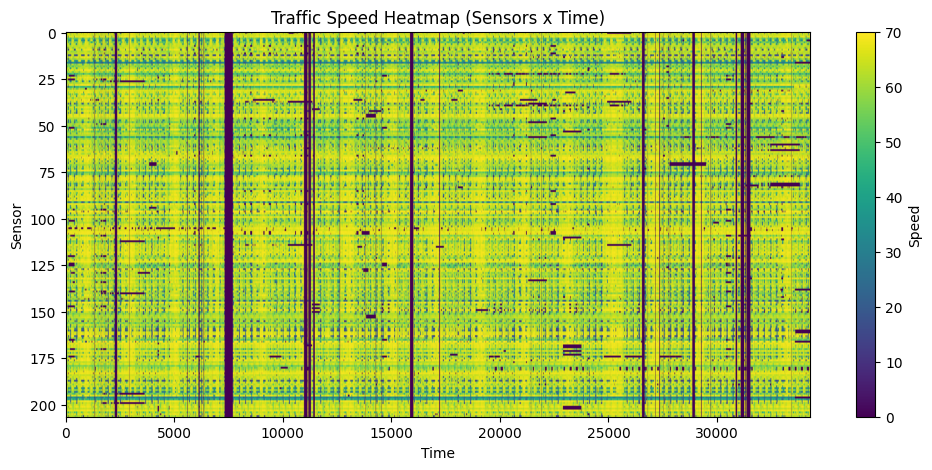

In [ ]:
plt.figure(figsize=(12,5))
plt.imshow(speeds.T, aspect='auto')
plt.colorbar(label="Speed")
plt.title("Traffic Speed Heatmap (Sensors x Time)")
plt.xlabel("Time")
plt.ylabel("Sensor")
plt.show()

In [ ]:
# 1722 edges in the graph
edge_index, edge_attr = adj_to_edge_index(adj)
print(edge_index.shape)
print(edge_attr.shape)

torch.Size([2, 1722])
torch.Size([1722, 1])


In [ ]:
graph = make_pyg_graph(edge_index, edge_attr, num_nodes=adj.shape[0])
print(graph)

Data(edge_index=[2, 1722], edge_attr=[1722, 1], num_nodes=207)


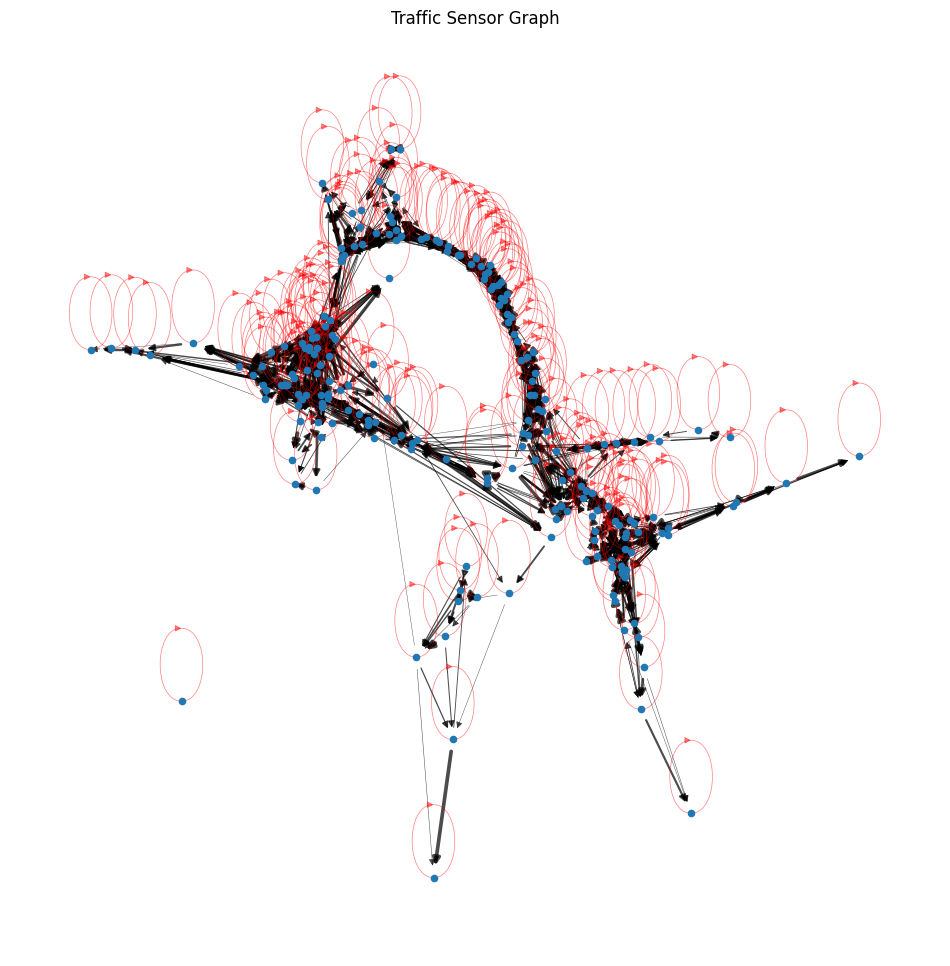

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()
num_nodes = adj.shape[0]

G.add_nodes_from(range(num_nodes))

rows, cols = edge_index.numpy()
weights = edge_attr.numpy().flatten()
for i in range(len(rows)):
    G.add_edge(rows[i], cols[i], weight=weights[i])

# separate self-loops and normal edges
self_loops = [(u,v) for u,v in G.edges() if u==v]
normal_edges = [(u,v) for u,v in G.edges() if u!=v]

pos = nx.spring_layout(G, seed=222)

plt.figure(figsize=(12,12))
nx.draw_networkx_nodes(G, pos, node_size=20)

nx.draw_networkx_edges(
    G, pos,
    edgelist=normal_edges,
    width=[G[u][v]['weight']*3 for u,v in normal_edges],  # scale width by weight
    alpha=0.7
)

# self-loops (smaller width)
nx.draw_networkx_edges(
    G, pos,
    edgelist=self_loops,
    width=0.5,
    alpha=0.5,
    edge_color='red',
    connectionstyle="arc3,rad=0.3"
)

plt.title("Traffic Sensor Graph")
plt.axis("off")
plt.show()


In [ ]:
seq_len = 36
horizon_steps = [1, 3, 6, 12]  # 5, 15, 30, 60 min

T = speeds.shape[0]  # time steps
train_end = int(T * 0.7) # 70%
val_end = int(T * 0.85) # 15%
# test - 15%

speeds_train = speeds[:train_end]
speeds_val = speeds[train_end - seq_len : val_end]
speeds_test = speeds[val_end - seq_len : ]

dataset_train = TrafficDatasetMultiHorizon(speeds_train, graph, seq_len, horizon_steps)
dataset_val = TrafficDatasetMultiHorizon(speeds_val, graph, seq_len, horizon_steps)
dataset_test = TrafficDatasetMultiHorizon(speeds_test, graph, seq_len, horizon_steps)

loader_train = DataLoader(dataset_train, batch_size=128, shuffle=True)
loader_val = DataLoader(dataset_val, batch_size=128, shuffle=False)
loader_test = DataLoader(dataset_test, batch_size=128, shuffle=False)

print(f"Train samples: {len(dataset_train)}")
print(f"Val samples: {len(dataset_val)}")
print(f"Test samples: {len(dataset_test)}")

Train samples: 23942
Val samples: 5129
Test samples: 5129


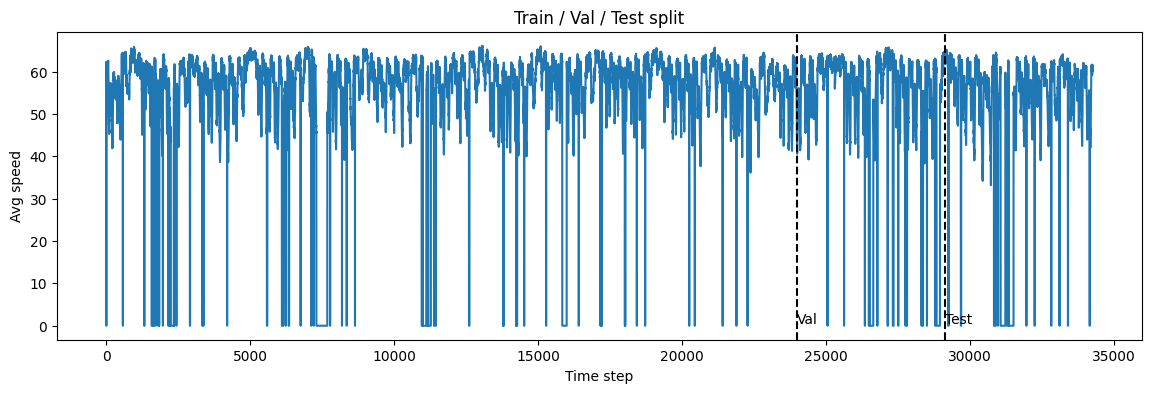

In [ ]:
plt.figure(figsize=(14,4))
plt.plot(np.mean(speeds, axis=1))
plt.axvline(train_end, color='black', linestyle='--')
plt.axvline(val_end, color='black', linestyle='--')
plt.title("Train / Val / Test split")
plt.xlabel("Time step")
plt.ylabel("Avg speed")
plt.text(train_end, np.max(np.mean(speeds, axis=1))*0.01, "Val", fontsize=10)
plt.text(val_end, np.max(np.mean(speeds, axis=1))*0.01, "Test", fontsize=10)
plt.show()

## Initialize model

ResidualGatedGCNN consist of ResGatedGraphConv layers

In [ ]:
class ResidualGatedGCNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=3, dropout=0.05, edge_dim=1):
        super().__init__()
        self.convs = nn.ModuleList()
        self.norms = nn.ModuleList()
        self.dropout = nn.Dropout(dropout)

        self.temp_conv = nn.Conv1d(in_channels=1, out_channels=hidden_channels, kernel_size=3, padding=1)

        for _ in range(num_layers):
            self.convs.append(ResGatedGraphConv(hidden_channels, hidden_channels, edge_dim=edge_dim, dropout=dropout))
            self.norms.append(nn.LayerNorm(hidden_channels))

        self.lin = nn.Linear(hidden_channels, out_channels)
        self.activation = nn.LeakyReLU(negative_slope=0.2)

    def forward(self, x, edge_index, edge_attr):
        if x.dim() == 2:
            x = x.unsqueeze(-1)  # [num_nodes, seq_len, 1]
        x = x.transpose(1, 2)  # [num_nodes, features, seq_len]
        x = self.temp_conv(x)   # [num_nodes, hidden_channels, seq_len]
        x = self.activation(x)
        x = x.mean(dim=-1)

        for conv, norm in zip(self.convs, self.norms):
            x_res = x
            x = conv(x, edge_index, edge_attr)
            x = norm(x)
            x = self.activation(x)
            x = self.dropout(x)
            x = x + x_res
        return self.lin(x)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ResidualGatedGCNN(
    in_channels=seq_len,
    hidden_channels=128,
    out_channels=len(horizon_steps),
    num_layers=2,
    edge_dim=1
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
)

## Train model

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

In [ ]:
epochs = 10

train_losses, val_losses = [], []
mae_list, rmse_list, r2_list, mape_list = [], [], [], []

In [ ]:
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in loader_train:
        batch = batch.to(device)
        optimizer.zero_grad()

        pred = model(batch.x, batch.edge_index, batch.edge_attr)
        loss = criterion(pred, batch.y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * batch.num_nodes

    total_loss /= len(loader_train.dataset)
    train_losses.append(total_loss)

    model.eval()
    val_loss = 0
    y_true, y_pred = [], []
    with torch.no_grad():
        for batch in loader_val:
            batch = batch.to(device)
            pred = model(batch.x, batch.edge_index, batch.edge_attr)
            val_loss += criterion(pred, batch.y).item() * batch.num_nodes

            y_true.append(batch.y.cpu().numpy())
            y_pred.append(pred.cpu().numpy())

    val_loss /= len(loader_val.dataset)
    val_losses.append(val_loss)

    y_true = np.concatenate(y_true, axis=0)
    y_pred = np.concatenate(y_pred, axis=0)

    scheduler.step(val_loss)

    # compute metrics for each horizon
    mae_epoch, rmse_epoch, r2_epoch, mape_epoch = [], [], [], []
    for i in range(y_true.shape[1]):
        y_t = y_true[:, i]
        y_p = y_pred[:, i]

        mae_epoch.append(mean_absolute_error(y_t, y_p))
        rmse_epoch.append(np.sqrt(mean_squared_error(y_t, y_p)))
        r2_epoch.append(r2_score(y_t, y_p))
        mape_epoch.append(mean_absolute_percentage_error(y_t, y_p) * 100)

    mae_list.append(mae_epoch)
    rmse_list.append(rmse_epoch)
    r2_list.append(r2_epoch)
    mape_list.append(mape_epoch)

    metrics_str = "\n".join([f"H{i+1}: MAE={mae_epoch[i]:.4f}, MAPE={mape_epoch[i]:.4f} RMSE={rmse_epoch[i]:.4f}, R2={r2_epoch[i]:.4f}"
                             for i in range(len(mae_epoch))])

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {total_loss:.4f}, Val Loss: {val_loss:.4f}")
    print(f"Metrics:\n{metrics_str}")


Epoch 1/10, Train Loss: 113.6459, Val Loss: 124.9498
Metrics:
H1: MAE=0.4131, MAPE=291.2196 RMSE=0.7175, R2=0.4883
H2: MAE=0.4535, MAPE=219.2338 RMSE=0.7532, R2=0.4361
H3: MAE=0.4678, MAPE=239.3919 RMSE=0.7964, R2=0.3694
H4: MAE=0.4931, MAPE=262.6055 RMSE=0.8355, R2=0.3052
Epoch 2/10, Train Loss: 84.8053, Val Loss: 95.4482
Metrics:
H1: MAE=0.3861, MAPE=191.5666 RMSE=0.5648, R2=0.6830
H2: MAE=0.4124, MAPE=225.6351 RMSE=0.6323, R2=0.6026
H3: MAE=0.4521, MAPE=225.3011 RMSE=0.7174, R2=0.4883
H4: MAE=0.5067, MAPE=202.6227 RMSE=0.7816, R2=0.3919
Epoch 3/10, Train Loss: 76.2584, Val Loss: 85.8187
Metrics:
H1: MAE=0.2778, MAPE=244.2989 RMSE=0.5130, R2=0.7384
H2: MAE=0.2967, MAPE=266.7568 RMSE=0.5855, R2=0.6592
H3: MAE=0.3518, MAPE=295.8526 RMSE=0.6768, R2=0.5446
H4: MAE=0.4640, MAPE=228.6700 RMSE=0.7709, R2=0.4085
Epoch 4/10, Train Loss: 73.4671, Val Loss: 81.2694
Metrics:
H1: MAE=0.2385, MAPE=254.0987 RMSE=0.4758, R2=0.7750
H2: MAE=0.2852, MAPE=254.5484 RMSE=0.5672, R2=0.6802
H3: MAE=0.3466, 

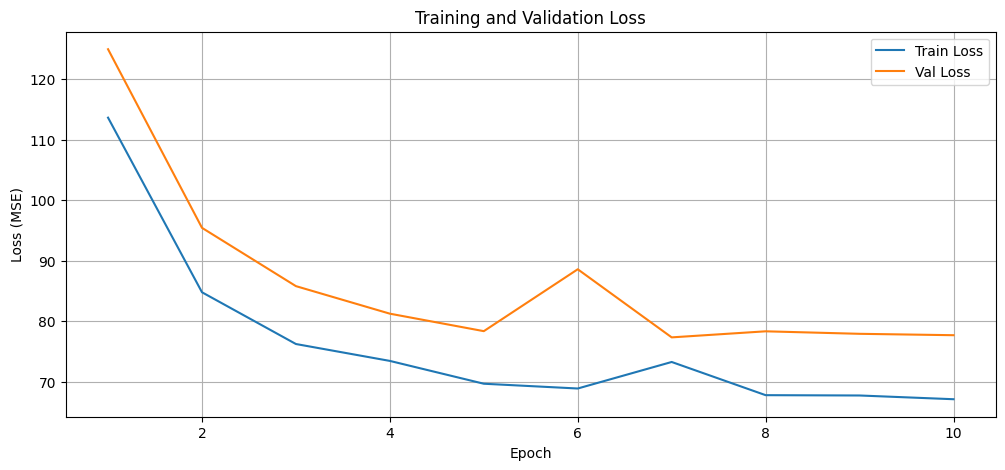

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(range(1, epochs+1), train_losses, label="Train Loss")
plt.plot(range(1, epochs+1), val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

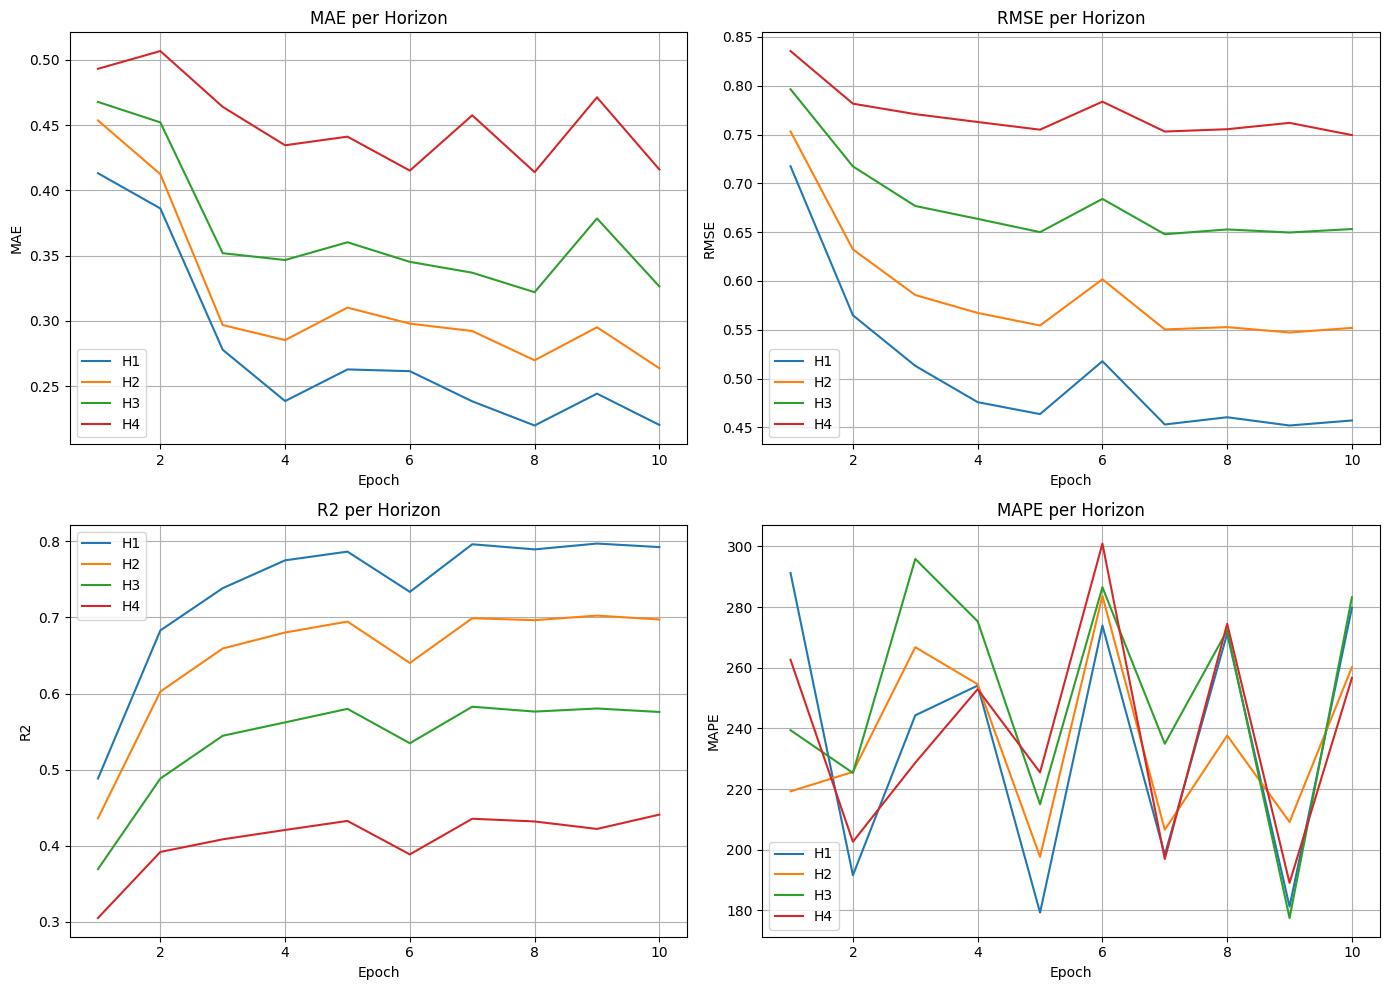

In [ ]:
mae_list = np.array(mae_list)
rmse_list = np.array(rmse_list)
r2_list = np.array(r2_list)
mape_list = np.array(mape_list)

horizons = range(1, y_true.shape[1]+1)

plt.figure(figsize=(14,10))

for idx, metric, name in zip([0,1,2,3], [mae_list, rmse_list, r2_list, mape_list], ["MAE", "RMSE", "R2", "MAPE"]):
    plt.subplot(2,2,idx+1)
    for h in range(len(horizons)):
        plt.plot(range(1, epochs+1), metric[:, h], label=f"H{h+1}")
    plt.title(f"{name} per Horizon")
    plt.xlabel("Epoch")
    plt.ylabel(name)
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

## Test model

In [ ]:
model.eval()
y_true, y_pred = [], []

for batch in loader_test:
    batch = batch.to(device)
    pred = model(batch.x, batch.edge_index, batch.edge_attr)
    y_pred.append(pred.detach().cpu().numpy())
    y_true.append(batch.y.cpu().numpy())

y_true = np.concatenate(y_true, axis=0)
y_pred = np.concatenate(y_pred, axis=0)

for i, h in enumerate(horizon_steps):
    mae = mean_absolute_error(y_true[:, i], y_pred[:, i])
    rmse = np.sqrt(mean_squared_error(y_true[:, i], y_pred[:, i]))
    r2 = r2_score(y_true[:, i], y_pred[:, i])
    print(f"Horizon {h*5} min → MAE: {mae:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")


Horizon 5 min → MAE: 0.2021, RMSE: 0.3967, R2: 0.8433
Horizon 15 min → MAE: 0.2409, RMSE: 0.4787, R2: 0.7719
Horizon 30 min → MAE: 0.3051, RMSE: 0.5754, R2: 0.6703
Horizon 60 min → MAE: 0.4097, RMSE: 0.6936, R2: 0.5210
